# Feature Crosses

### Learning objectives:
* Improve the Linear Regression model with addition of additional synthetic features
* Use input functions to convert pandas DataFrame objects to Tensors and invote fit() and predict() operations
* Use FTRL Optimization algorithm for model training 
* Create new synthetic features through one-hot encoding, binning and feature crosses.

## Setup

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index)
)

In [2]:
def preprocess_features(california_housing_dataframe):
    """Prepares input features from California housing data set.
    
    Args:
        california_housing_dataframe: A Pandas DataFrame expected to contain data
        from the California housing data set.
    Returns:
        A DataFrame that contains the features to be used for the model, including 
        synthetic features.
    """
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    # Create a synthetic feature.
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e., labels) from California housing data set.
    
    Args:
        california_housing_dataframe: A Pandas DataFrame expected to contain data
        from the California housing data set.
    Returns:
        A DataFrame that contains the target feature.
    """
    output_targets = pd.DataFrame()
    # Scale the target to be in units of thousands of dollars.
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2636.2,539.2,1425.8,500.8,3.9,2.0
std,2.1,2.0,12.5,2175.4,423.7,1125.4,385.4,1.9,1.1
min,32.5,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1459.8,296.0,787.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2126.0,434.0,1167.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3136.2,647.0,1718.2,603.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2661.7,539.8,1438.6,502.2,3.9,2.0
std,2.1,2.0,12.7,2190.9,416.3,1200.2,382.4,1.9,1.2
min,32.5,-124.3,2.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1471.0,299.0,795.0,283.0,2.6,1.5
50%,34.3,-118.5,29.0,2129.0,435.0,1167.5,409.0,3.6,1.9
75%,37.7,-118.0,37.0,3192.2,652.0,1726.0,610.0,4.8,2.3
max,41.9,-114.3,52.0,30405.0,4957.0,35682.0,4769.0,15.0,52.0


Training targets summary:


,median_house_value
count,12000.0
mean,206.7
std,115.8
min,15.0
25%,119.1
50%,179.7
75%,264.0
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.8
std,116.4
min,15.0
25%,120.3
50%,181.6
75%,268.3
max,500.0


In [4]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
    
    Args:
        input_features: The names of the numerical input features to use.
    Returns:
        A set of feature columns
    """
    return set([tf.feature_column.numeric_column(my_feature)
                for my_feature in input_features])

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## FTRL Optimization Algorithm

High dimensional Linear models benefit from using a variant of gradient-based optimization called as FTRL. This algorithm as benefit from scaling the learning rate differently for different coefficients, which can be useful if some features rarely takes non-zero values (it also is well suited to support L1 regularization). We can apply FTRL using the FtrlOptimizer

In [8]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """ Trains a Linear Regression Model.
    
    In addition to training, this function also prints training progress information,
    as well as plot the training and validation loss over the time.
    
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step consists of
            a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `Dataframe` containing one or more columns from 
            `california_housing_dataframe` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for validation.
    Returns:
        A `LinearRegressor` object trained on the training data.
    """
    periods = 10
    steps_per_period = steps / periods
    
    # Create a Linear Regressor object
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
    training_input_fn = lambda: my_input_fn(training_examples,
                                           training_targets["median_house_value"],
                                           batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                   training_targets["median_house_value"],
                                                   num_epochs=1,
                                                   shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                     validation_targets["median_house_value"],
                                                     num_epochs=1,
                                                     shuffle=False)
    
    # Train the model but do so inside the loop so we can periodically assess
    # loss metrics
    print("Training model...")
    print("RMSE (on training model):")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets)
        )
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets)
        )
        # Occasionally prints the current loss
        print(" period %02d: %0.2f" %(period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model trainign finished.")
    
    # Output a graph of loss metrics over a period
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root mean squared error vs Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor
        
        

Training model...
RMSE (on training model):
 period 00: 213.67
 period 01: 196.71
 period 02: 162.02
 period 03: 126.78
 period 04: 123.79
 period 05: 192.78
 period 06: 142.85
 period 07: 182.88
 period 08: 163.46
 period 09: 170.30
Model trainign finished.


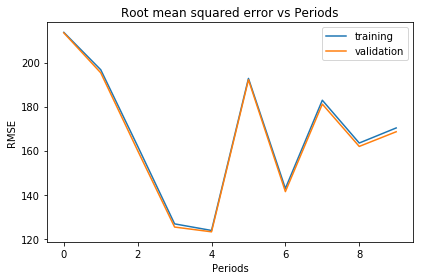

In [9]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets
)

## One-Hot Encoding for discrete features

Discrete (eg. strings, enum, integers) features are usually converted into families of features before training a logistic regression model. For example, suppose we created 

## Bucketized (binning) features

We can bucketized (bin) features based on their range too. For example, population can be put into buckets like below:
* bucket_0 (<5000): Corresponds to the less populated blocks
* bucket_1 (5000-25000): Corresponds to the mid-populated blocks
* bucket_2 (>25000): Highly populated blocks

Now we can also apply one-hot encoding on such kind of features.

In [18]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

# Divide household into 7 buckets.
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
        california_housing_dataframe["households"], 7
    )
)

# Divide longitude into 10 buckets.
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
        california_housing_dataframe["longitude"], 10
    )
)

## Task 1: Train model on bucketized features

In [19]:
def construct_feature_columns():
    """Construct the TensorFlow Feature Columns.
    
    Returns:
        A set of feature columns
    """ 
    households = tf.feature_column.numeric_column("households")
    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf.feature_column.numeric_column("latitude")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
    
    # Divide households into 7 buckets.
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_quantile_based_boundaries(
            training_examples["households"], 7))
    
    # Divide longitude into 10 buckets.
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries=get_quantile_based_boundaries(
            training_examples["longitude"], 10))
    
    # Divide latitude into 10 buckets.
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_quantile_based_boundaries(
            training_examples["latitude"], 10))
    
    # Divide housing_median_age into 7 buckets.
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_quantile_based_boundaries(
            training_examples["housing_median_age"], 7))
    
    # Divide median_income into 7 buckets. 
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_quantile_based_boundaries(
            training_examples["median_income"], 7))
    
    # Divide rooms_per_person into 7 buckets.
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_quantile_based_boundaries(
            training_examples["rooms_per_person"], 7))
    
    feature_columns = set([
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person])
    
    return feature_columns

Training model...
RMSE (on training model):
 period 00: 169.02
 period 01: 142.78
 period 02: 126.39
 period 03: 115.31
 period 04: 107.56
 period 05: 101.84
 period 06: 97.37
 period 07: 93.76
 period 08: 90.84
 period 09: 88.41
Model trainign finished.


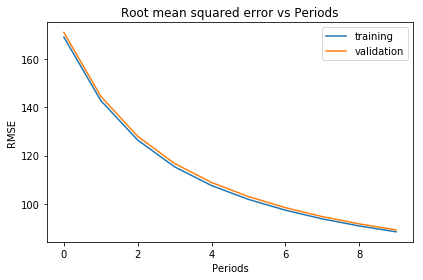

In [20]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Train model using Feature Crosses

Will add feature of latitude and longitude to make a feature cross

In [21]:
def construct_feature_columns():
    """Construct the TensorFlow Feature Columns.
    
    Returns:
        A set of feature columns
    """ 
    households = tf.feature_column.numeric_column("households")
    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf.feature_column.numeric_column("latitude")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
    
    # Divide households into 7 buckets.
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_quantile_based_boundaries(
            training_examples["households"], 7))
    
    # Divide longitude into 10 buckets.
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries=get_quantile_based_boundaries(
            training_examples["longitude"], 10))
    
    # Divide latitude into 10 buckets.
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_quantile_based_boundaries(
            training_examples["latitude"], 10))
    
    # Divide housing_median_age into 7 buckets.
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_quantile_based_boundaries(
            training_examples["housing_median_age"], 7))
    
    # Divide median_income into 7 buckets.
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_quantile_based_boundaries(
            training_examples["median_income"], 7))
    
    # Divide rooms_per_person into 7 buckets.
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_quantile_based_boundaries(
            training_examples["rooms_per_person"], 7))
    
    # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
    long_x_lat = tf.feature_column.crossed_column(
        set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
    
    feature_columns = set([
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person,
        long_x_lat])
    
    return feature_columns

Training model...
RMSE (on training model):
 period 00: 162.69
 period 01: 134.46
 period 02: 117.31
 period 03: 106.09
 period 04: 98.19
 period 05: 92.41
 period 06: 87.86
 period 07: 84.24
 period 08: 81.41
 period 09: 78.98
Model trainign finished.


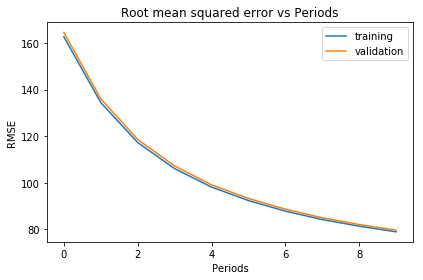

In [22]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)